## Семинар 2 "Распознавание рукописных цифр"

ФИО: Окутин Денис Алексеевич

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
%matplotlib inline

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

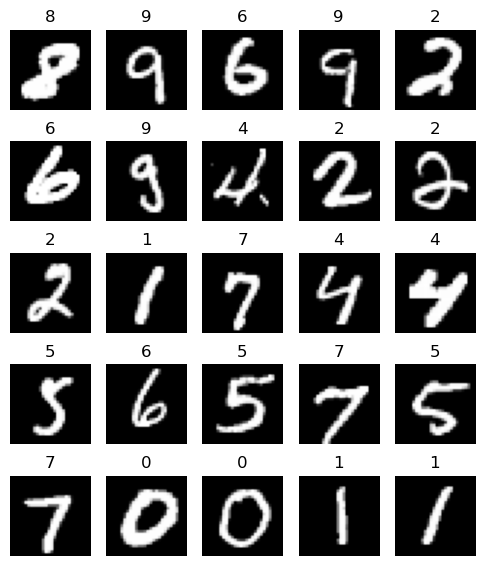

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [5]:
from tqdm import tqdm
def train(network,train_loader, test_loader, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in tqdm(range(epochs)):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [6]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.305/0.298	Accuracy: 0.920/0.921

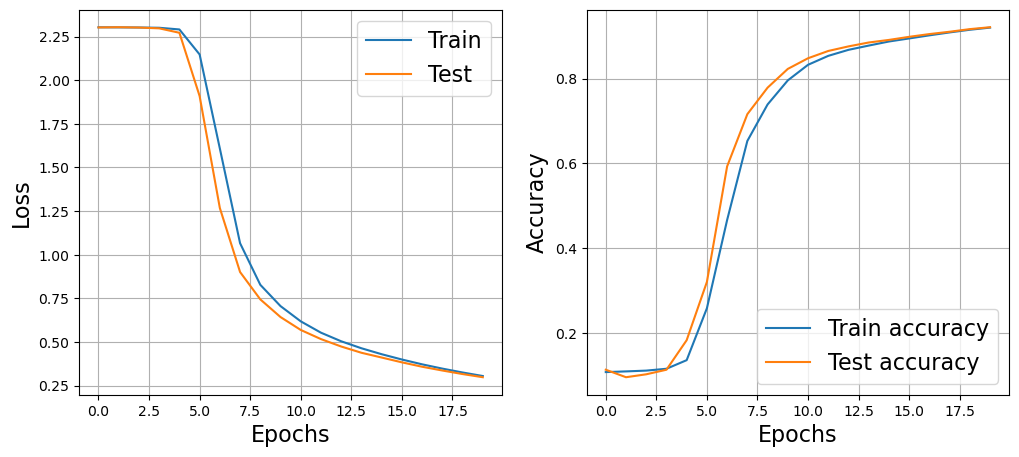

100%|██████████| 20/20 [04:46<00:00, 14.33s/it]


In [7]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network,train_loader,test_loader, 20, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [8]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [9]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.037/0.085	Accuracy: 0.990/0.977

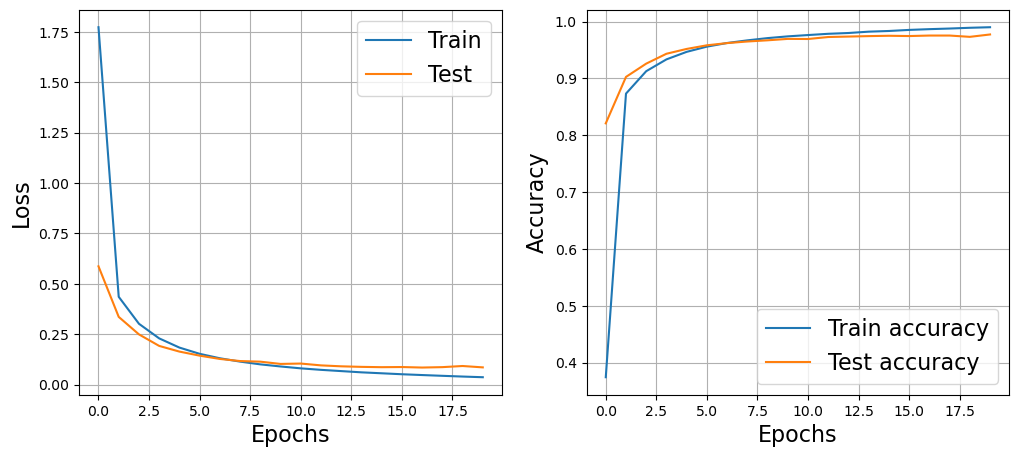

100%|██████████| 20/20 [05:47<00:00, 17.36s/it]


In [10]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network,train_loader,test_loader, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.049/0.082	Accuracy: 0.986/0.975

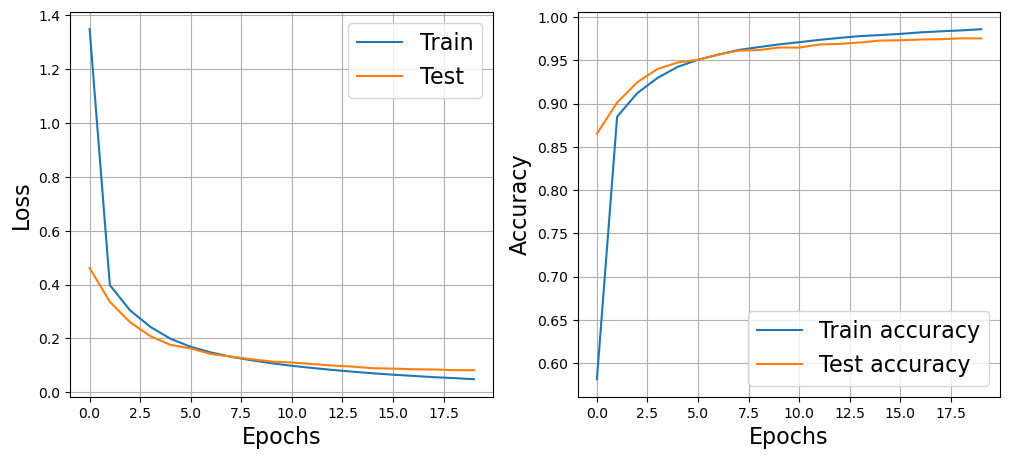

100%|██████████| 20/20 [05:03<00:00, 15.19s/it]


In [11]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network,train_loader,test_loader, 20, 0.01, plot=True, verbose=True)

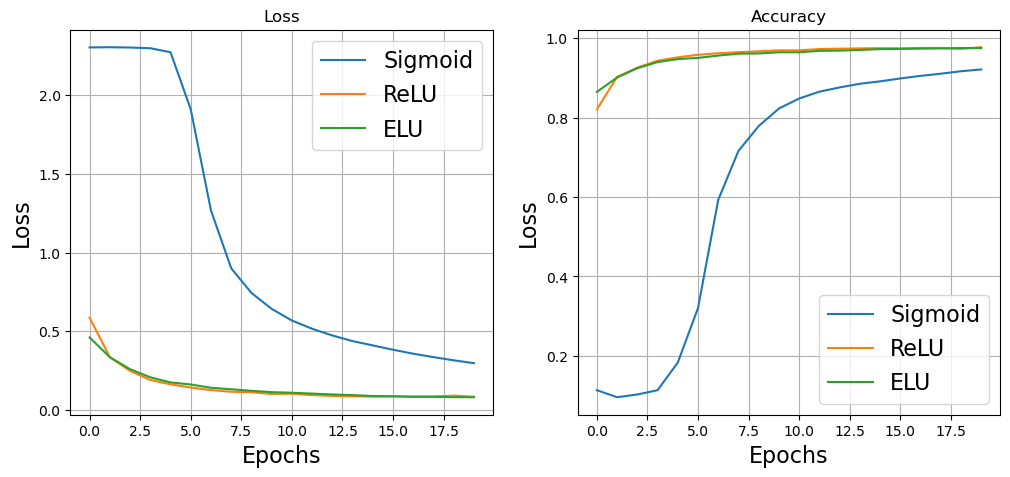

In [12]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### HW1 (1 балл): Реализовать Tanh

In [13]:
class Tanh:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return (2./(1+np.exp(-2*X)))-1.

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = 4./(np.exp(2*X)+2+np.exp(-2*X))
        return dLdy*dydX

    def step(self, learning_rate):
        pass

In [14]:
network = NeuralNetwork([
    Linear(784, 100), Tanh(),
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.031/0.079	Accuracy: 0.994/0.975

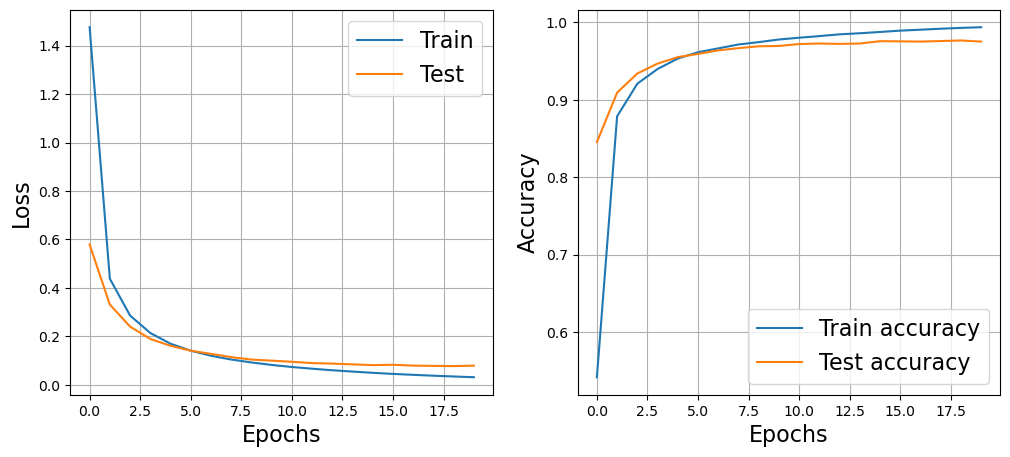

100%|██████████| 20/20 [04:33<00:00, 13.68s/it]


In [15]:
tr_th, ts_th, tr_ac_th, ts_ac_th = train(network,train_loader,test_loader,20, 0.01, plot=True, verbose=True)

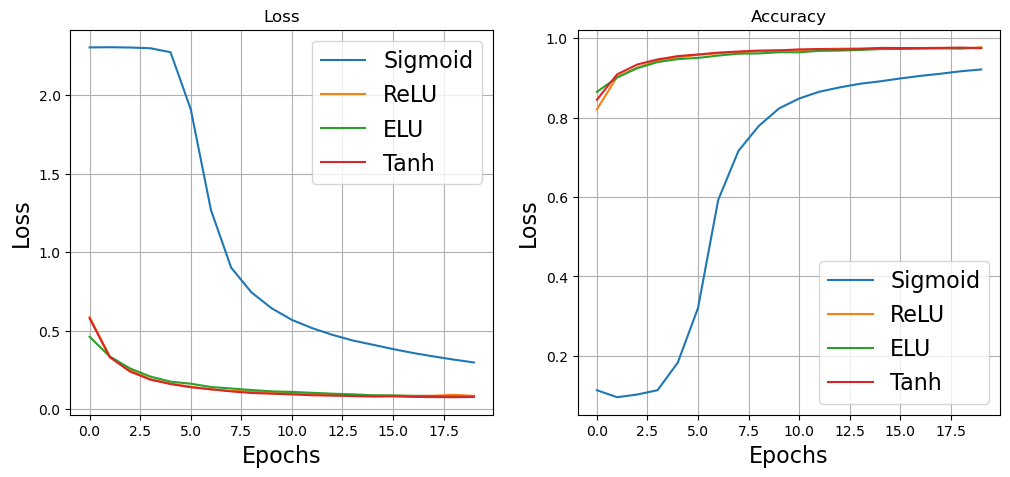

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_th,label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_th,label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 3: Анализ ошибок

In [17]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

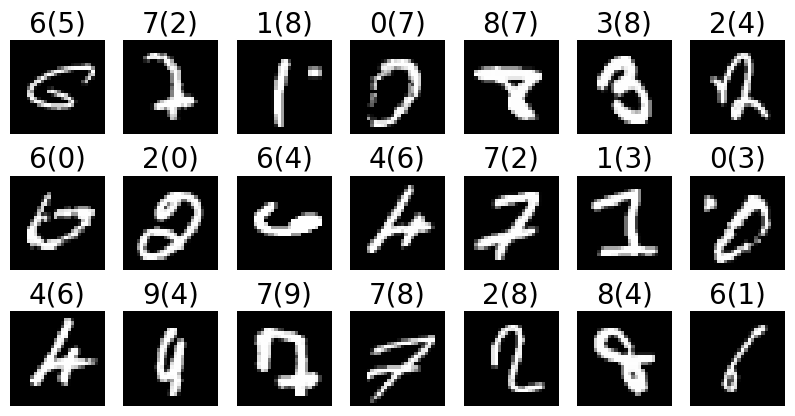

In [18]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

## Аугментация случайными вращениями

Epoch 19... (Train/Test) NLL: 0.079/0.072	Accuracy: 0.976/0.977

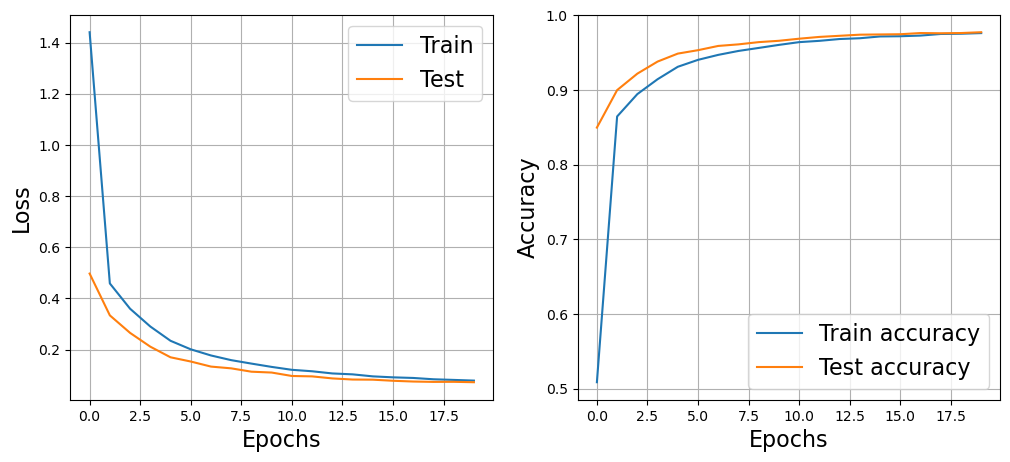

100%|██████████| 20/20 [05:34<00:00, 16.71s/it]


In [19]:
from skimage.transform import rotate
transform_rotation = transforms.Compose([
                       transforms.RandomRotation(15),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform_rotation)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


network = NeuralNetwork([Linear(784, 100), ELU(),
           Linear(100, 100), ELU(),
           Linear(100, 10)])

tr_l_r, ts_l_r, tr_a_r, ts_a_r = train(network, train_loader, test_loader, 20, 0.01)

## Аугментация случайными сдвигами

Epoch 19... (Train/Test) NLL: 0.078/0.063	Accuracy: 0.976/0.981

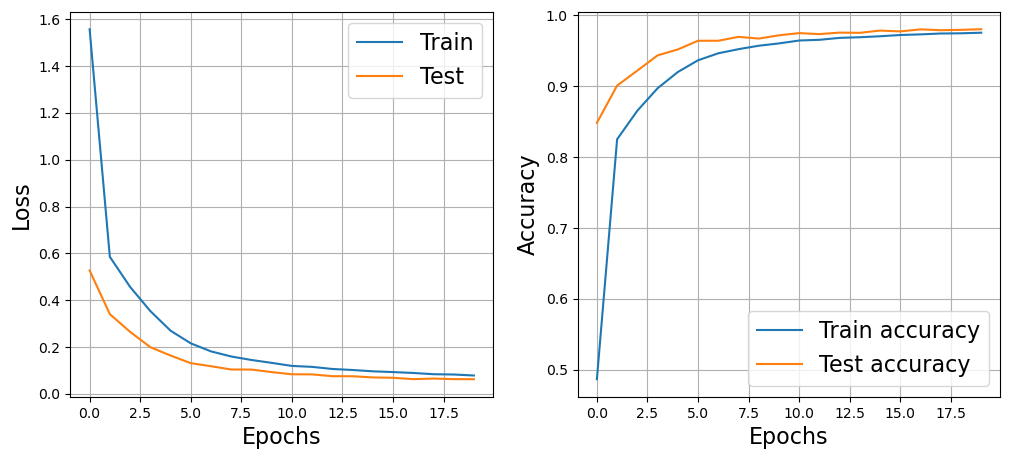

100%|██████████| 20/20 [06:21<00:00, 19.08s/it]


In [20]:
transform_shift = transforms.Compose([
                       transforms.RandomAffine(degrees=0,translate=(0.05,0.05)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform_shift)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


network = NeuralNetwork([Linear(784, 100), ELU(),
           Linear(100, 100), ELU(),
           Linear(100, 10)])

tr_l_s, ts_l_s, tr_a_s, ts_a_s = train(network, train_loader, test_loader, 20, 0.01)

## Аугментация шумом


Epoch 19... (Train/Test) NLL: 0.077/0.135	Accuracy: 0.976/0.962

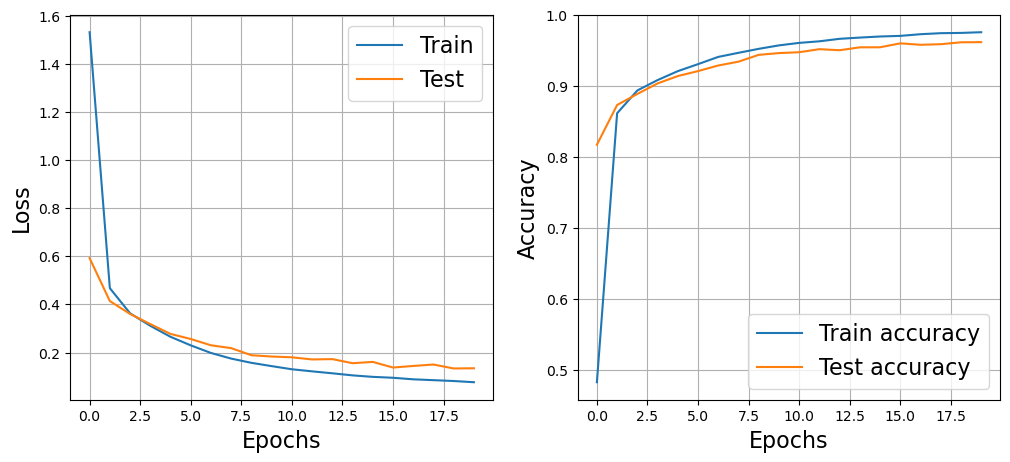

100%|██████████| 20/20 [07:47<00:00, 23.39s/it]


In [21]:
from skimage.util import random_noise
import torch

transform_noise = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Lambda(lambda x: torch.tensor(random_noise(x, mode='gaussian',
                                                                             mean=0, var=0.05, clip=True))),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform_noise)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


network = NeuralNetwork([Linear(784, 100), ELU(),
           Linear(100, 100), ELU(),
           Linear(100, 10)])

tr_l_n, ts_l_n, tr_a_n, ts_a_n = train(network, train_loader, test_loader, 20, 0.01)

## Комплексная аугментация

Epoch 19... (Train/Test) NLL: 0.140/0.163	Accuracy: 0.956/0.953

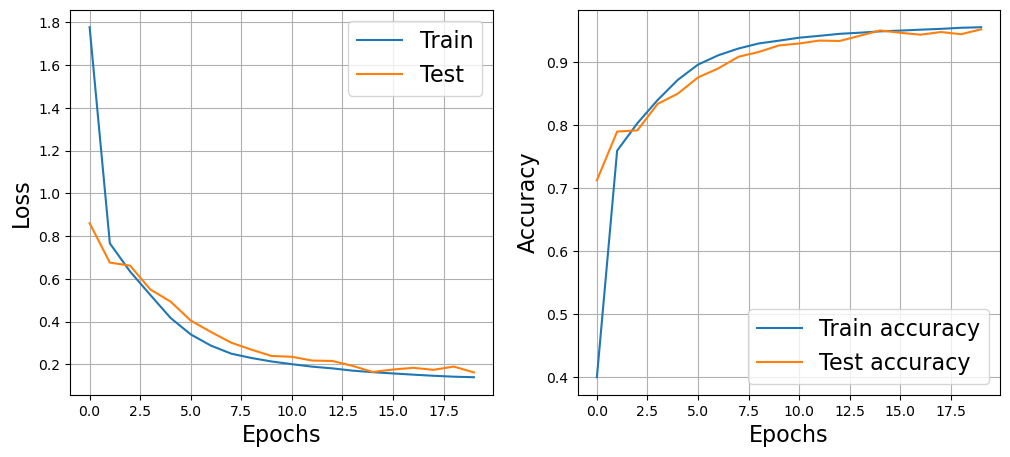

100%|██████████| 20/20 [09:35<00:00, 28.76s/it]


In [22]:
transform_compl = transforms.Compose([
                        transforms.RandomAffine(degrees=15,translate=(0.05,0.05)),
                       transforms.ToTensor(),
                       transforms.Lambda(lambda x: torch.tensor(random_noise(x, mode='gaussian',
                                                                             mean=0, var=0.05, clip=True))),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform_compl)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


network = NeuralNetwork([Linear(784, 100), ELU(),
           Linear(100, 100), ELU(),
           Linear(100, 10)])

tr_l_c, ts_l_c, tr_a_c, ts_a_c = train(network, train_loader, test_loader, 20, 0.01)

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

#### Нелинейности:
    1) Sigmoid = (Train/Test) NLL: 0.295/0.294 Accuracy: 0.923/0.921 5min 28s
    2) RELU = (Train/Test) NLL: 0.037/0.083	Accuracy: 0.990/0.975 5min 20s
    3) ELU = (Train/Test) NLL: 0.049/0.081	Accuracy: 0.986/0.976 6min 33s
    4) Tanh = (Train/Test) NLL: 0.031/0.078	Accuracy: 0.994/0.974 5min 30s

По соотношению скорость/качество лучшими нелинейными функциями активации оказались RELU и Tanh. ELU также показало
хорошие результаты, но оно обучается дольше на 1 минуту, что может быть существенно на более сложных задачах.

#### Аугментации:
     1) Вращения (Train/Test) NLL: 0.079/0.072	Accuracy: 0.976/0.977
     2) Смещение (Train/Test) NLL: 0.078/0.063	Accuracy: 0.976/0.981
     3) Шум (Train/Test) NLL: 0.077/0.135	Accuracy: 0.976/0.962
     4) Композиция аугментаций (Train/Test) NLL: 0.140/0.163	Accuracy: 0.956/0.953

Случайные сдвиги и вращения улучшают качество модели, шум наоборот. Композиция аугментаций только ухудшила результаты.